In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
# import math

# def logaritmica(c,r):
#     return c * np.log(1 + r)


# def log_aplicada(imagem):
#     c = 255 / np.log(1 + np.max(imagem))
#     # Cria uma imagem resultado com o mesmo shape da imagem de entrada
#     result = np.empty_like(imagem)
    
#     altura, largura = imagem.shape[:2]
#     for i in range(altura):
#         for j in range(largura):
#             result[i, j] = logaritmica(c, imagem[i][j])
#     return result

class log_aplicada_torch(object):
    
    def logaritmica(self, c,r):
        return c * torch.log(1 + r)

    def __call__(self, imagem):
        c = 255 / torch.log(1 + torch.max(imagem))
        # Cria uma imagem resultado com o mesmo shape da imagem de entrada
        result = torch.empty_like(imagem)
        
        altura, largura = imagem.shape[:2]
        for i in range(altura):
            for j in range(largura):
                result[i, j] = self.logaritmica(c, imagem[i][j])
        return result


In [4]:
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1), transforms.ToTensor(), log_aplicada_torch()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=6,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=6,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


0.5
128.0
(3, 36, 206)


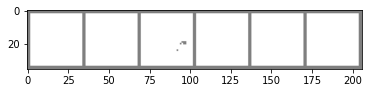

plane truck  frog truck


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.min(npimg))
    print(np.max(npimg))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

img_transform = images[0]
img_transform_2 = images[1]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
img_transform

tensor([[[182.5378, 182.5378, 184.7543,  ..., 188.0580, 189.1537, 190.2466],
         [179.1915, 180.3098, 180.3098,  ..., 179.1915, 181.4252, 183.6475],
         [180.3098, 183.6475, 184.7543,  ..., 178.0703, 180.3098, 183.6475],
         ...,
         [234.8031, 223.8348, 234.8031,  ..., 229.8520, 229.8520, 225.8498],
         [217.7326, 128.1420, 146.6426,  ..., 166.6951, 162.0599, 158.5506],
         [178.0703, 130.6550, 116.6493,  ..., 197.8203, 189.1537, 185.8584]]])

In [9]:
img_transform_2

tensor([[[232.6367, 232.6367, 231.6788,  ..., 223.9360, 216.0487, 213.0527],
         [239.2824, 242.0989, 244.8967,  ..., 221.9779, 217.0427, 217.0427],
         [244.8967, 246.7517, 248.5986,  ..., 220.9954, 220.0107, 218.0343],
         ...,
         [181.8636, 185.0880, 186.1574,  ..., 201.8819, 201.8819, 187.2241],
         [180.7833, 186.1574, 190.4081,  ..., 178.6144, 186.1574, 173.1429],
         [206.9961, 205.9782, 209.0246,  ..., 172.0400, 178.6144, 170.9343]]])

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class classificador(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3))
    self.conv2 = nn.Conv2d(32, 32, (3, 3))
    self.activation = nn.ReLU()
    self.bnorm = nn.BatchNorm2d(num_features=32)
    self.pool = nn.MaxPool2d(kernel_size = (2,2))
    self.flatten = nn.Flatten()

    # output = (input - filter + 1) / stride
    # convolução 1: (28 - 3 + 1) / 1 = 30x30
    # pooling 1: 15x15
    # convolução 2: (15 - 3 + 1) / 1 = 13x13
    # pooling 2: 6x6
    # 6 * 6 * 32
    # 800 -> 128 -> 128 -> 10
    self.linear1 = nn.Linear(in_features=32*6*6, out_features=128)
    self.linear2 = nn.Linear(128, 128)
    self.output = nn.Linear(128, 10)
    self.dropout = nn.Dropout(p = 0.2)

  def forward(self, X):
    X = self.pool(self.bnorm(self.activation(self.conv1(X))))
    X = self.pool(self.bnorm(self.activation(self.conv2(X))))
    X = self.flatten(X)

    X = self.dropout(self.activation(self.linear1(X)))
    X = self.dropout(self.activation(self.linear2(X)))
    X = self.output(X)

    return X


net = classificador()

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.848
[1,  4000] loss: 1.542
[1,  6000] loss: 1.434
[1,  8000] loss: 1.341
[2,  2000] loss: 1.245
[2,  4000] loss: 1.225
[2,  6000] loss: 1.192
[2,  8000] loss: 1.176
[3,  2000] loss: 1.073
[3,  4000] loss: 1.066
[3,  6000] loss: 1.063
[3,  8000] loss: 1.072
[4,  2000] loss: 0.963
[4,  4000] loss: 0.992
[4,  6000] loss: 0.978
[4,  8000] loss: 0.987
[5,  2000] loss: 0.878
[5,  4000] loss: 0.916
[5,  6000] loss: 0.927
[5,  8000] loss: 0.929
Finished Training


0.5
128.0
(3, 36, 206)


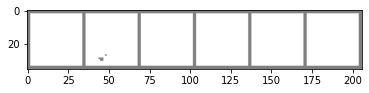

GroundTruth:    cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
outputs = net(images)

In [17]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car plane  ship


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 64 %


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 80 %
Accuracy of  bird : 49 %
Accuracy of   cat : 40 %
Accuracy of  deer : 55 %
Accuracy of   dog : 57 %
Accuracy of  frog : 71 %
Accuracy of horse : 73 %
Accuracy of  ship : 78 %
Accuracy of truck : 73 %
